In [385]:
%pylab inline
import pandas as pd
import seaborn as sns
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.ensemble import RandomForestRegressor
import sys
from sklearn.model_selection import train_test_split
import pydot
#imports the own created package
import bookie_package as bp
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


In [386]:
leagues_short = ['E0'] #spanish league, bundesliga, premier league,
leagues_full = ['premier_league']
dict_historical_data = {}

for league, full_name in zip(leagues_short, leagues_full):
    frames = []
    for i in range(17, 20):
        df = pd.read_csv("http://www.football-data.co.uk/mmz4281/"+str(i)+str(i+1)+"/"+league+".csv")
        print(f'Getting {full_name}-{i}{i+1}...')
        df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HST', 'AST']] #choose any column you want
        df = df.assign(Season=i)
        frames.append(df)
    df_historical_data = pd.concat(frames)
    dict_historical_data[full_name] = df_historical_data

Getting Eredivisie-1718...
Getting Eredivisie-1819...
Getting Eredivisie-1920...


In [387]:
for league in leagues_full:
    HTGDIFF = []
    ATGDIFF = []
    for index, row in dict_historical_data[league].iterrows():
        HTGDIFF.append(row['FTHG'] - row['FTAG'])
        ATGDIFF.append(-(row['FTHG'] - row['FTAG']))
    dict_historical_data[league]['HTGDIFF'] = HTGDIFF
    dict_historical_data[league]['ATGDIFF'] = ATGDIFF

dict_historical_data[league]['Date'] = pd.to_datetime(dict_historical_data[league]['Date'], errors='coerce')
dict_historical_data[league]['Day'] = dict_historical_data[league]['Date'].dt.day
dict_historical_data[league]['Month'] = dict_historical_data[league]['Date'].dt.month
dict_historical_data[league]['Year'] = dict_historical_data[league]['Date'].dt.year
dict_historical_data[league] = dict_historical_data[league][['Day','Month','Year','HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HST', 'AST', 'HTGDIFF', 'ATGDIFF']]

dict_historical_data[league]=dict_historical_data[league].sort_values(['Year', 'Month','Day'], ascending=False)
df_both_seasons_home = dict_historical_data[league]

## Add avg Home Team Goal Difference

In [388]:
# calculates the average home team goal difference across the last 10 hosting games
d_both_seasons = bp.averages.avg_goal_diff(df_both_seasons_home, 'AVGHTGDIFF', 'HomeTeam', 'H')

In [389]:
df_both_seasons = bp.averages.from_dict_value_to_df(d_both_seasons)

In [390]:
df_both_seasons=df_both_seasons.sort_values(['Year', 'Month','Day'], ascending=False)

In [391]:
# calculates the average goals shot by the home team across the last 10 hosting games
avg_fthg_per_team=bp.averages.avg_goals(df_both_seasons, 'AVGFTHG', 'HomeTeam', 'H')

In [392]:
df_both_seasons = bp.averages.from_dict_value_to_df(avg_fthg_per_team)

In [393]:
df_both_seasons=df_both_seasons.sort_values(['Year', 'Month','Day'], ascending=False)

In [394]:
df_both_seasons.columns

Index(['Day', 'Month', 'Year', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HST',
       'AST', 'HTGDIFF', 'ATGDIFF', 'AVGHTGDIFF', 'AVGFTHG'],
      dtype='object')

In [395]:
df_both_seasons.head()

,Day,Month,Year,HomeTeam,AwayTeam,FTHG,FTAG,HST,AST,HTGDIFF,ATGDIFF,AVGHTGDIFF,AVGFTHG
194,2,11,2020,FC Emmen,Twente,2,0,5,2,2,-2,1.5,2.4
195,2,11,2020,Sparta Rotterdam,Den Haag,4,2,8,4,2,-2,1.6,2.5
228,3,8,2020,Utrecht,Sparta Rotterdam,5,1,6,1,4,-4,1.4,2.5
229,3,8,2020,Feyenoord,Willem II,2,0,3,0,2,-2,1.0,2.2
230,3,8,2020,Heracles,Waalwijk,4,2,10,4,2,-2,1.7,3.2


## Add Columns with previous HTGDIFF and HST for each HomeTeam

In [396]:
# HTGDIFF values from the last ten home team games, per past match
team_with_past_HTGDIFF=bp.averages.previous_data(df_both_seasons, 'HomeTeam', 'HTGDIFF')

In [397]:
df_team_with_past_HTGDIFF = bp.averages.from_dict_value_to_df(team_with_past_HTGDIFF)

In [398]:
columns_HTGDIFF = [
    'Day', 'Month', 'Year', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
    'HTGDIFF', 'ATGDIFF', 'AVGHTGDIFF','AVGFTHG', 'HST', 'AST',  'HTGDIFF_1', 'HTGDIFF_2', 'HTGDIFF_3', 'HTGDIFF_4', 'HTGDIFF_5', 'HTGDIFF_6', 'HTGDIFF_7',
    'HTGDIFF_8', 'HTGDIFF_9', 'HTGDIFF_10'
]

In [399]:
df_team_with_past_HTGDIFF = df_team_with_past_HTGDIFF.reindex(columns=columns_HTGDIFF)

In [400]:
df_team_with_past_HTGDIFF.fillna(0, inplace=True)

In [401]:
# HST values from the last ten home team games, per past match
team_with_past_HST=bp.averages.previous_data(df_team_with_past_HTGDIFF, 'HomeTeam', 'HST')

In [402]:
df_team_with_past_HST = bp.averages.from_dict_value_to_df(team_with_past_HST)

In [403]:
columns_HST =  ['HST_1', 'HST_2', 'HST_3', 'HST_4', 'HST_5', 'HST_6', 'HST_7', 'HST_8', 'HST_9', 'HST_10']
columns_HTGDIFF_HST = columns_HTGDIFF + columns_HST

In [404]:
df_team_with_past_HST = df_team_with_past_HST.reindex(columns=columns_HTGDIFF_HST)

In [405]:
df_team_with_past_HST.fillna(0, inplace=True)

In [406]:
# FTHG values from the last ten home team games, per past match
team_with_past_FTHG = bp.averages.previous_data(df_team_with_past_HST, 'HomeTeam', 'FTHG')

In [407]:
df_team_with_past_FTHG = bp.averages.from_dict_value_to_df(team_with_past_FTHG)

In [408]:
columns_FTHG = ['FTHG_1', 'FTHG_2', 'FTHG_3', 'FTHG_4', 'FTHG_5', 'FTHG_6', 'FTHG_7', 'FTHG_8', 'FTHG_9', 'FTHG_10']
columns_HTGDIFF_HST_FTHG = columns_HTGDIFF_HST + columns_FTHG

In [409]:

df_team_with_past_FTHG = df_team_with_past_FTHG.reindex(columns=columns_HTGDIFF_HST_FTHG)

In [410]:
#filling na to make data suitable for our model
df_team_with_past_FTHG.fillna(0, inplace=True)

In [411]:
df_result = df_team_with_past_FTHG.copy()

In [412]:
df_result.shape

(844, 43)

In [413]:
df_result = df_result.drop(['HomeTeam', 'AwayTeam'], axis = 1)

In [414]:
df_result.head()

,Day,Month,Year,FTHG,FTAG,HTGDIFF,ATGDIFF,AVGHTGDIFF,AVGFTHG,HST,...,FTHG_1,FTHG_2,FTHG_3,FTHG_4,FTHG_5,FTHG_6,FTHG_7,FTHG_8,FTHG_9,FTHG_10
194,2,11,2020,2,0,2,-2,1.5,2.4,5,...,3.0,4.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,1.0
225,3,7,2020,3,0,3,-3,1.1,2.3,7,...,4.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,1.0,2.0
206,22,2,2020,4,2,2,-2,1.0,2.2,7,...,1.0,2.0,2.0,1.0,3.0,3.0,3.0,1.0,2.0,2.0
169,19,1,2020,1,0,1,-1,1.0,2.0,6,...,2.0,2.0,1.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0
149,15,12,2019,2,0,2,-2,1.0,2.0,8,...,2.0,1.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0,2.0


In [415]:
print('Shape of features:', df_result.shape)

Shape of features: (844, 41)


## Define Targets and drop Columns

In [416]:
# values I want to predict
target = df_result['FTHG']

# values we want to predict and are not necessary for the random forrest regressor 
# or were identified as noise
df_result= df_result.drop([
    'FTHG','FTAG', 'HTGDIFF', 'ATGDIFF', 'HST', 'AST', 'HTGDIFF_7', 'HTGDIFF_9', 
    'HTGDIFF_10', 'FTHG_5', 'FTHG_8', 'FTHG_10', 'FTHG_4', 'FTHG_7', 'HST_6', 
    'FTHG_3'
], axis = 1)

In [417]:
df_result.columns

Index(['Day', 'Month', 'Year', 'AVGHTGDIFF', 'AVGFTHG', 'HTGDIFF_1',
       'HTGDIFF_2', 'HTGDIFF_3', 'HTGDIFF_4', 'HTGDIFF_5', 'HTGDIFF_6',
       'HTGDIFF_8', 'HST_1', 'HST_2', 'HST_3', 'HST_4', 'HST_5', 'HST_7',
       'HST_8', 'HST_9', 'HST_10', 'FTHG_1', 'FTHG_2', 'FTHG_6', 'FTHG_9'],
      dtype='object')

## Training and Testing Sets

In [418]:
# splitting arrays into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    df_result, target, test_size = 0.25,random_state = 42
)               

In [419]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (633, 25)
y_train Shape: (633,)
X_test Shape: (211, 25)
y_test Shape: (211,)


## Calculate Baseline

In [420]:
# as baseline we are going to use the HomeTeam Goal averages
features_names = list(df_result.columns)
X_train = np.array(X_train)
base = X_train[:, features_names.index('AVGFTHG')]
#subtracting train result from test data
baseline_errors = abs(base - y_train)
print('MAE: ', round(np.mean(baseline_errors), 2), 'Goals.')

MAE:  1.2 Goals.


## Train Model

In [421]:
# fitting the random forrest model at the begining with 1000 estimators
rf = bp.prediction.random_forrest(X_train, y_train, n_estimators=1000,random_state = 42)

## First Predictions on Test Data

In [422]:
bp.prediction.performance_accuracy(y_test,X_test, rf)

MAE: 1.04 Goals.
regr Accuracy: 27.49 %.


In [423]:
features=np.array(df_result)
predictions_FTHG = rf.predict(features)
next_games_predictions=np.round(predictions_FTHG,0)

In [424]:
#inserting predicted goals into original dataframe
df_both_seasons['FTHG'] = next_games_predictions
df_both_seasons.head()

,Day,Month,Year,HomeTeam,AwayTeam,FTHG,FTAG,HST,AST,HTGDIFF,ATGDIFF,AVGHTGDIFF,AVGFTHG
194,2,11,2020,FC Emmen,Twente,2.0,0,5,2,2,-2,1.5,2.4
195,2,11,2020,Sparta Rotterdam,Den Haag,3.0,2,8,4,2,-2,1.6,2.5
228,3,8,2020,Utrecht,Sparta Rotterdam,3.0,1,6,1,4,-4,1.4,2.5
229,3,8,2020,Feyenoord,Willem II,1.0,0,3,0,2,-2,1.0,2.2
230,3,8,2020,Heracles,Waalwijk,2.0,2,10,4,2,-2,1.7,3.2


### Single Decision Tree Visualising 

In [425]:
rf_depth_4 = bp.prediction.random_forrest(X_train, y_train, n_estimators=10,random_state = 42, max_depth = 4)

# randomly pick one tree from ten
tree_4 = rf_depth_4.estimators_[7]

# use export_graphviz to save the tree as a dot file first as indicated: 
# as described here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
export_graphviz(tree_4, out_file = 'tree_4_home.dot', feature_names = features_names, rounded = True, precision = 1)

# then use the dot file to create a png file 
(graph, ) = pydot.graph_from_dot_file('tree_4_home.dot')
graph.write_png('tree_4_home.png');

In [426]:
print('The depth of this tree is:', tree_4.tree_.max_depth)

The depth of this tree is: 4


### Variable Importances in %

In [427]:
# creates a list of feature names and their importance
importance = np.round(rf.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:15} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGFTHG         20.42%
Feature Importance: AVGHTGDIFF      7.15%
Feature Importance: Day             5.31%
Feature Importance: HST_1           4.29%
Feature Importance: HTGDIFF_3       4.19%
Feature Importance: HTGDIFF_5       4.19%
Feature Importance: HST_3           4.13%
Feature Importance: HST_4           4.01%
Feature Importance: HST_2           3.99%
Feature Importance: HTGDIFF_2       3.49%
Feature Importance: Month           3.43%
Feature Importance: HTGDIFF_1       3.37%
Feature Importance: HST_5           3.09%
Feature Importance: HST_10          2.97%
Feature Importance: HST_9           2.94%
Feature Importance: HST_8           2.9%
Feature Importance: HTGDIFF_8       2.8%
Feature Importance: HST_7           2.66%
Feature Importance: HTGDIFF_6       2.52%
Feature Importance: HTGDIFF_4       2.47%
Feature Importance: FTHG_1          2.32%
Feature Importance: FTHG_2          2.3%
Feature Importance: FTHG_6          1.91%
Feature Importance: FTHG_9          

## Feature Reduction

In [428]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk')

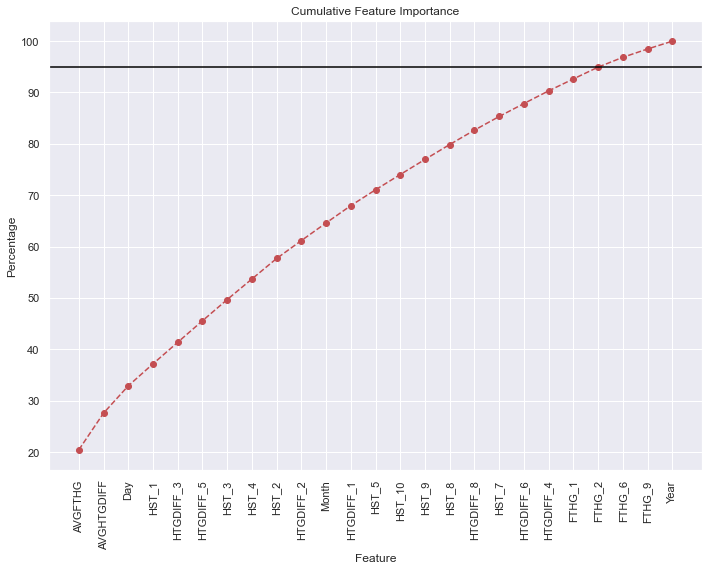

In [429]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
bottom, top = ylim()
bottom = 0
cum_values=np.cumsum(values)
plt.plot(names,cum_values, '--bo', color='r')
# set importance at 95%
plt.axhline(95,color='black')
plt.xticks(rotation=90);
plt.xlabel('Feature'); 
plt.ylabel('Percentage'); 
plt.title('Cumulative Feature Importance');

## Random Forest Optimization through Random Search

In [430]:
from sklearn.model_selection import RandomizedSearchCV

In [431]:
rs = bp.prediction.random_search(X_train,y_train,cv=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [432]:
best_params = rs.best_params_

In [433]:
#best params calculated by our search algorithm (rs)
best_params

{'n_estimators': 777,
 'min_samples_split': 2,
 'max_leaf_nodes': 31,
 'max_features': 'auto',
 'max_depth': 14,
 'bootstrap': True}

In [434]:
# reuses newly calculated params
rfc = bp.prediction.random_forrest(
    X_train, y_train, 
    n_estimators=best_params['n_estimators'],
    random_state = 42,
    min_samples_split = best_params['min_samples_split'],
    max_leaf_nodes = best_params['max_leaf_nodes'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap']
)


In [435]:
# recalculates new Mean Absolute Error and accuracy
bp.prediction.performance_accuracy(y_test,X_test, rfc)

MAE: 1.0 Goals.
regr Accuracy: 31.28 %.


In [436]:
next_games=df_result
# predicts new results with newly calculated params
predictions_next_games = rf.predict(next_games)
next_games_predictions=np.round(predictions_next_games,0)

In [437]:
df_both_seasons['FTHG'] = next_games_predictions
df_both_seasons.head()

,Day,Month,Year,HomeTeam,AwayTeam,FTHG,FTAG,HST,AST,HTGDIFF,ATGDIFF,AVGHTGDIFF,AVGFTHG
194,2,11,2020,FC Emmen,Twente,2.0,0,5,2,2,-2,1.5,2.4
195,2,11,2020,Sparta Rotterdam,Den Haag,3.0,2,8,4,2,-2,1.6,2.5
228,3,8,2020,Utrecht,Sparta Rotterdam,3.0,1,6,1,4,-4,1.4,2.5
229,3,8,2020,Feyenoord,Willem II,1.0,0,3,0,2,-2,1.0,2.2
230,3,8,2020,Heracles,Waalwijk,2.0,2,10,4,2,-2,1.7,3.2


In [438]:
df_both_seasons.to_excel('df_both_seasons_home.xlsx')